In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import xarray as xr
import pickle
#import h5py
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If available, print the name of the GPU
if cuda_available:
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

def save_dict_to_pickle(data_dict, save_path):
    """
    Saves a dictionary to a specified path using pickle.
    
    Parameters:
    data_dict (dict): The dictionary to save.
    save_path (str): The file path where the dictionary will be saved.
    """
    with open(save_path, 'wb') as file:
        pickle.dump(data_dict, file)

class SeaIceDataset(Dataset):
    def __init__(self, data_directory, configuration, split_array, start_prediction_months, \
                split_type='train', target_shape=(336, 320)):
        self.data_directory = data_directory
        self.configuration = configuration
        self.split_array = split_array
        self.start_prediction_months = start_prediction_months
        self.split_type = split_type
        self.target_shape = target_shape

        # Open the HDF5 files
        self.inputs_file = h5py.File(f"{data_directory}/inputs_{configuration}.h5", 'r')
        self.targets_file = h5py.File(f"{data_directory}/targets.h5", 'r')
        
        self.inputs = self.inputs_file[f"inputs_{configuration}"]
        self.targets = self.targets_file['targets_sea_ice_only']

        self.n_samples, self.n_channels, self.n_y, self.n_x = self.inputs.shape
        
        # Get indices for the specified split type
        self.indices = np.where(self.split_array == split_type)[0]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        input_data = self.inputs[actual_idx]
        target_data = self.targets[actual_idx]
        start_prediction_month = self.start_prediction_months[actual_idx]

        # Pad input_data and target_data to the target shape
        pad_y = self.target_shape[0] - self.n_y
        pad_x = self.target_shape[1] - self.n_x
        input_data = np.pad(input_data, ((0, 0), (pad_y//2, pad_y//2), (pad_x//2, pad_x//2)), mode='constant', constant_values=0)
        target_data = np.pad(target_data, ((0, 0), (pad_y//2, pad_y//2), (pad_x//2, pad_x//2)), mode='constant', constant_values=0)

        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        target_tensor = torch.tensor(target_data, dtype=torch.float32)

        # Get the target months for this sample
        target_months = pd.date_range(start=start_prediction_month, end=start_prediction_month + pd.DateOffset(months=5), freq="MS")
        target_months = target_months.month.to_numpy()
        
        return input_tensor, target_tensor, target_months

    def __del__(self):
        self.inputs_file.close()
        self.targets_file.close()

class UNetRes3(nn.Module):
    def __init__(self, in_channels, out_channels, device, spatial_shape=(336, 320), n_channels_factor=1, filter_size=3):
        super(UNetRes3, self).__init__()

        self.encoder1 = self.conv_block(in_channels, int(64 * n_channels_factor), filter_size)
        self.encoder2 = self.conv_block(int(64 * n_channels_factor), int(128 * n_channels_factor), filter_size)
        self.encoder3 = self.conv_block(int(128 * n_channels_factor), int(256 * n_channels_factor), filter_size)

        self.bottleneck = self.conv_block(int(256 * n_channels_factor), int(512 * n_channels_factor), filter_size)
        
        self.decoder1_conv = self.conv(int(512 * n_channels_factor), int(256 * n_channels_factor), filter_size)
        self.decoder1_conv_block = self.conv_block(2 * int(256 * n_channels_factor), int(256 * n_channels_factor), filter_size)

        self.decoder2_conv = self.conv(int(256 * n_channels_factor), int(128 * n_channels_factor), filter_size)
        self.decoder2_conv_block = self.conv_block(2 * int(128 * n_channels_factor), int(128 * n_channels_factor), filter_size)

        self.decoder3_conv_1 = self.conv(int(128 * n_channels_factor), int(64 * n_channels_factor), filter_size)
        self.decoder3_conv_2 = self.conv(int(64 * n_channels_factor), int(64 * n_channels_factor), filter_size)
        
        self.final_conv = nn.Conv2d(int(64 * n_channels_factor), out_channels, kernel_size=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Make a land mask tensor that is the same shape as the output tensor
        land_mask_npy = ~xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask.data
        n_y, n_x = land_mask_npy.shape
        pad_y = spatial_shape[0] - n_y
        pad_x = spatial_shape[1] - n_x
        land_mask_npy = np.pad(land_mask_npy, ((pad_y//2, pad_y//2), (pad_x//2, pad_x//2)), mode='constant', constant_values=0)
        
        self.land_mask = torch.from_numpy(land_mask_npy).unsqueeze(0).repeat(6, 1, 1).to(device)
        
    def conv_block(self, in_channels, out_channels, filter_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=filter_size//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=filter_size, padding=filter_size//2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )
    
    def conv(self, in_channels, out_channels, filter_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=filter_size//2),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        bottleneck = self.bottleneck(self.pool(enc3))
        
        dec1 = self.upsample(bottleneck)
        dec1 = self.decoder1_conv(dec1)
        dec1 = torch.cat((enc3, dec1), dim=1)
        dec1 = self.decoder1_conv_block(dec1)
        
        dec2 = self.upsample(dec1)
        dec2 = self.decoder2_conv(dec2)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2_conv_block(dec2)
        
        dec3 = self.upsample(dec2)
        dec3 = self.decoder3_conv_1(dec3)
        dec3 = torch.cat((enc1, dec3), dim=1)
        dec3 = self.decoder3_conv_1(dec3)
        dec3 = self.decoder3_conv_2(dec3)
        dec3 = self.decoder3_conv_2(dec3)

        output = torch.sigmoid(self.final_conv(dec3))
        
        # Apply the land mask
        output = output * self.land_mask
        
        return output


class UNetRes4(nn.Module):
    def __init__(self, in_channels, out_channels, device, spatial_shape=(336, 320), n_channels_factor=1, filter_size=3):
        super(UNetRes4, self).__init__()
        self.encoder1 = self.conv_block(in_channels, int(64 * n_channels_factor), filter_size)
        self.encoder2 = self.conv_block(int(64 * n_channels_factor), int(128 * n_channels_factor), filter_size)
        self.encoder3 = self.conv_block(int(128 * n_channels_factor), int(256 * n_channels_factor), filter_size)
        self.encoder4 = self.conv_block(int(256 * n_channels_factor), int(512 * n_channels_factor), filter_size)

        self.bottleneck = self.conv_block(int(512 * n_channels_factor), int(1024 * n_channels_factor), filter_size)
        
        self.decoder1 = self.conv_block(int(1024 * n_channels_factor) + int(512 * n_channels_factor), int(256 * n_channels_factor), filter_size)
        self.decoder2 = self.conv_block(int(512 * n_channels_factor) + int(256 * n_channels_factor), int(256 * n_channels_factor), filter_size)
        self.decoder3 = self.conv_block(int(256 * n_channels_factor) + int(128 * n_channels_factor), int(128 * n_channels_factor), filter_size)
        self.decoder4 = self.conv_block(int(128 * n_channels_factor) + int(64 * n_channels_factor), int(64 * n_channels_factor), filter_size)
        
        self.final_conv = nn.Conv2d(int(64 * n_channels_factor), out_channels, kernel_size=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Make a land mask tensor that is the same shape as the output tensor
        land_mask_npy = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask.data
        n_y, n_x = land_mask_npy.shape
        pad_y = spatial_shape[0] - n_y
        pad_x = spatial_shape[1] - n_x
        land_mask_npy = np.pad(land_mask_npy, ((pad_y//2, pad_y//2), (pad_x//2, pad_x//2)), mode='constant', constant_values=0)
        
        self.land_mask = torch.from_numpy(land_mask_npy).unsqueeze(0).repeat(6, 1, 1).to(device)
        
    def conv_block(self, in_channels, out_channels, filter_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=filter_size//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=filter_size, padding=filter_size//2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        bottleneck = self.bottleneck(self.pool(enc3))
        
        dec1 = self.upsample(bottleneck)
        dec1 = torch.cat((enc3, dec1), dim=1)
        dec1 = self.decoder1(dec1)
        
        dec2 = self.upsample(dec1)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec3 = self.upsample(dec2)
        dec3 = torch.cat((enc1, dec3), dim=1)
        dec3 = self.decoder3(dec3)

        output = torch.sigmoid(self.final_conv(dec3))
        
        # Apply the land mask
        output = output * self.land_mask
        
        return output


class MaskedMSELoss(nn.Module):
    def __init__(self, use_weights, zero_class_weight=None):
        super(MaskedMSELoss, self).__init__()
        self.ice_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/monthly_ice_mask.nc").mask
        self.use_weights = use_weights
        self.zero_class_weight = zero_class_weight

    def forward(self, outputs, targets, target_months):
        n_active_cells = 0

        for target_months_subset in target_months:
            n_active_cells += self.ice_mask.sel(month=target_months_subset.cpu()).sum().values
        
        # Punish predictions of sea ice in ice free zones 
        if self.use_weights:
            weights = torch.where(targets == 0, self.zero_class_weight, 1)
            loss = torch.sum(((targets - outputs) ** 2) * weights) / n_active_cells
        else:
            loss = torch.sum((targets - outputs) ** 2) / n_active_cells

        return loss


TRAIN_MONTHS = pd.date_range(start='1981-01-01', end='2014-12-01', freq='MS')
VAL_MONTHS = pd.date_range(start='2015-01-01', end='2018-12-01', freq='MS')
TEST_MONTHS = pd.date_range(start='2019-01-01', end='2024-06-01', freq='MS')

# Construct the date range for the data pairs 
# Note that this is not continuous due to the missing data in 1987-1988 
first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=6+1), freq='MS')
second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=12+1), '2024-01', freq='MS')
start_prediction_months = first_range.append(second_range)

split_array = np.empty(np.shape(start_prediction_months), dtype=object)
for i,month in enumerate(start_prediction_months):
    if month in TRAIN_MONTHS: split_array[i] = "train"
    if month in VAL_MONTHS: split_array[i] = "val"
    if month in TEST_MONTHS: split_array[i] = "test"

def print_split_stats(split_array):
    ntrain = sum(split_array == 'train')
    nval = sum(split_array == 'val')
    ntest = sum(split_array == 'test')
    
    print(f"train samples: {ntrain} ({round(ntrain / len(split_array), 2)}) \n \
    val samples: {nval} ({round(nval / len(split_array), 2)}) \n \
    test samples: {ntest} ({round(ntest / len(split_array), 2)})")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNetRes3(in_channels=23, out_channels=6, device=device, n_channels_factor=1, filter_size=3).to(device)

criterion = MaskedMSELoss(use_weights=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print_split_stats(split_array)

model_hyperparam_configs={
    "name": "unet_resolution3",
    "input_config": "simple", 
    "lr": "1e-4", 
    "optimizer": "adam",
    "zeros_weight": "none",
    "notes": "fixed concatenation in the architecture and added more conv layers at the end"
}

CUDA available: True
Device name: NVIDIA A100-SXM4-40GB
Device count: 1
train samples: 388 (0.78) 
     val samples: 48 (0.1) 
     test samples: 61 (0.12)


In [31]:
import h5py

data_directory = os.path.join(DATA_DIRECTORY, 'sicpred/data_pairs_npy')
configuration = 'simple'
batch_size = 32

# Create dataset instances for training, validation, and testing
train_dataset = SeaIceDataset(data_directory, configuration, split_array, start_prediction_months, split_type='train', target_shape=(336, 320))
val_dataset = SeaIceDataset(data_directory, configuration, split_array, start_prediction_months, split_type='val', target_shape=(336, 320))
test_dataset = SeaIceDataset(data_directory, configuration, split_array, start_prediction_months, split_type='test', target_shape=(336, 320))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)


In [32]:
num_epochs = 75

train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets, target_months in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets, target_months)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, target_months in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets, target_months)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")

# Testing loop (optional)
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets, target_months in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets, target_months)
        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

# Save the trained model
os.makedirs(f"{DATA_DIRECTORY}/sicpred/models", exist_ok=True)
model_full_name = f"UNetRes3_no_zeros_weight"

save_dict_to_pickle(model_hyperparam_configs, f"{DATA_DIRECTORY}/sicpred/models/{model_full_name}.pkl")
torch.save(model.state_dict(), f"{DATA_DIRECTORY}/sicpred/models/{model_full_name}.pth")


KeyboardInterrupt: 

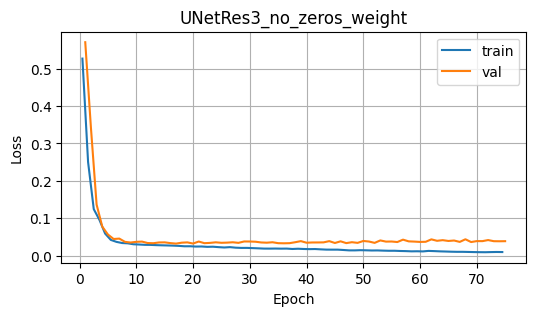

In [ ]:

plt.figure(figsize=(6,3))
plt.plot(np.arange(0.5, 75.5, 1), train_losses, label="train")
plt.plot(np.arange(1, 76, 1), val_losses, label="val")
plt.legend()
plt.title(model_full_name)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

plt.savefig(f"../figures/training_curves/{model_full_name}_training_curve", bbox_inches='tight', dpi=300)



In [ ]:
from torchsummary import summary
summary(model, input_size=(23, 336, 320))


ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
# model_full_name = f"{model_configs['name']}_{configuration}_lr{model_configs['lr']}_epoch80_{model_configs['optimizer']}_weightzeros"

# model_state_path = os.path.join(f"{DATA_DIRECTORY}/sicpred/models/{model_full_name}.pth")

# model.load_state_dict(torch.load(model_state_path, map_location=device))

model.eval()
test_loss = 0.0
inputs_list = []
outputs_list = []
targets_list = []

with torch.no_grad():
    for inputs, targets, target_months in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        inputs_list.append(inputs)
        outputs_list.append(outputs)
        targets_list.append(targets)
        loss = criterion(outputs, targets, target_months)
        print(loss.item() * inputs.size(0))


1.20041024684906
0.667724609375


In [ ]:
test_output = outputs_list[10][0,0,:,:]
test_target = targets_list[10][0,0,:,:]
test_output_modified = torch.where(test_output < 0.1, 0, test_output)

target_months_instance = torch.tensor([1,2,3,4,5,6])
print(f"original loss: {criterion(test_output, test_target, target_months_instance)}")
print(f"changed to zeros loss: {criterion(test_output_modified, test_target, target_months_instance)}")

original loss: 0.005505776964128017
changed to zeros loss: 0.003430865705013275


In [ ]:
nsdic_sic = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")


Text(0.5, 0.98, 'Prediction for 12/2017 at 4 lead month')

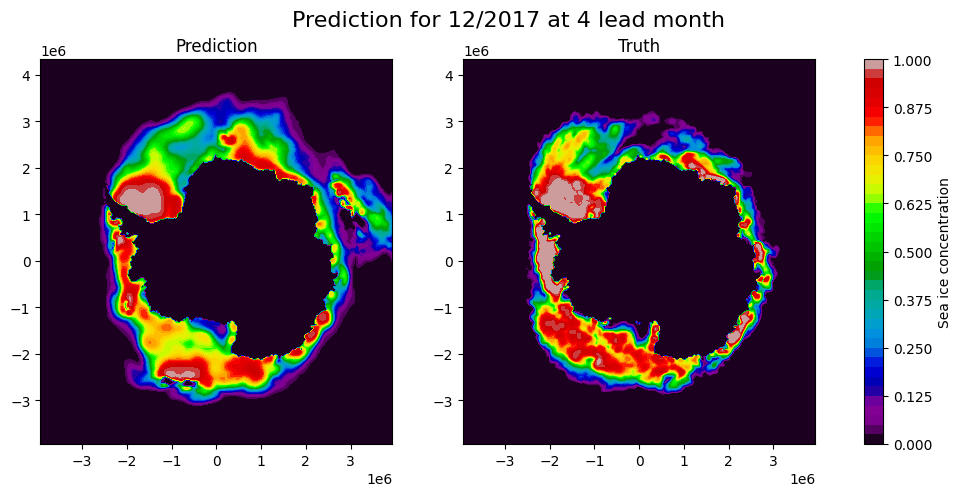

In [70]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

month_index = 0
lead_time = 3
list_elem = 1

ax1.contourf(nsdic_sic.xgrid, nsdic_sic.ygrid, outputs_list[list_elem][month_index,lead_time,2:334,2:318].cpu(), cmap='nipy_spectral',\
    levels=np.arange(0,1.025,0.025))
cax = ax2.contourf(nsdic_sic.xgrid, nsdic_sic.ygrid, targets_list[list_elem][month_index,lead_time,2:334,2:318].cpu(), cmap='nipy_spectral',\
    levels=np.arange(0,1.025,0.025))

ax1.set_title("Prediction")
ax2.set_title("Truth")

cbar = fig.colorbar(cax, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('Sea ice concentration')

predicted_month = VAL_MONTHS[month_index + lead_time + list_elem*batch_size]

plt.suptitle(rf"Prediction for {predicted_month.month:02}/{predicted_month.year} at {lead_time+1} lead month", fontsize=16)
#plt.savefig(f"../figures/sample_predictions/{model_full_name}_{predicted_month.month:02}_{predicted_month.year}_lead_{lead_time+1}.jpg", dpi=300, bbox_inches='tight')

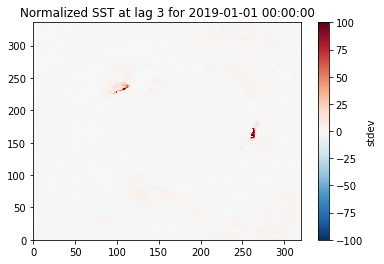

In [ ]:
month_index = 0
list_elem = 0

predicted_month = TEST_MONTHS[month_index + list_elem*batch_size]

plt.pcolormesh(inputs_list[list_elem][month_index,20,:,:].cpu(), vmin=-100, vmax=100, cmap="RdBu_r")
plt.title(f"Normalized SST at lag 3 for {predicted_month}")
plt.colorbar(label='stdev')
plt.savefig("../figures/known_issues/large_normalized_sst_at_ice_edge.jpg", dpi=300, bbox_inches='tight')


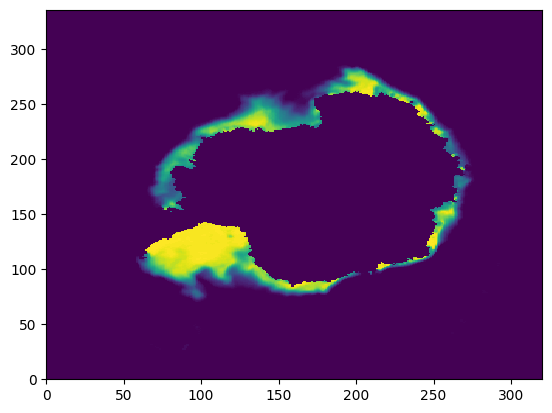

In [ ]:
plt.pcolormesh(inputs_list[list_elem][month_index,2,:,:].cpu())
